# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from pandas import concat

In [3]:
import functions as f

### Functions

In [52]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Preparing the Data

In [4]:
df = pd.read_csv("datasets/csvs/Seq_Hotel.csv")
pos_df = df.drop(['v_x', 'v_y'], axis = 1)
pos_grp = pos_df.groupby('pedestrian_ID')

In [5]:
for name, group in pos_grp:
    print(group)
    

    frame_number  pedestrian_ID     pos_x     pos_y
0              0              1  1.398378 -5.743303
10             1              1  1.267545 -6.415418
    frame_number  pedestrian_ID     pos_x     pos_y
1              0              2  0.517796 -7.003832
11             1              2  0.556995 -7.655782
    frame_number  pedestrian_ID     pos_x     pos_y
2              0              3  2.259814 -4.546597
12             1              3  1.899369 -4.071787
20             2              3  1.489720 -3.428552
26             3              3  1.105262 -2.944155
32             4              3  0.815252 -2.407553
38             5              3  0.404631 -1.953971
44             6              3  0.145386 -1.476325
49             7              3 -0.129565 -0.913360
54             8              3 -0.366306 -0.332841
58             9              3 -0.565479  0.244458
62            10              3 -0.787035  0.786265
66            11              3 -0.954758  1.260439
70          

5190          1519            344  0.866762 -6.524511
      frame_number  pedestrian_ID     pos_x     pos_y
5078          1496            345  2.072593 -9.998276
5083          1497            345  2.106328 -9.379270
5088          1498            345  2.197129 -8.724457
5091          1499            345  2.288770 -8.051514
5094          1500            345  2.363018 -7.359254
5097          1501            345  2.472384 -6.691285
5101          1502            345  2.546213 -6.002511
5105          1503            345  2.602825 -5.293965
5108          1504            345  2.731605 -4.594138
5111          1505            345  2.804838 -3.910550
5114          1506            345  2.967750 -3.238916
5117          1507            345  3.074190 -2.602579
5120          1508            345  3.166633 -1.887941
5123          1509            345  3.307048 -1.279749
5126          1510            345  3.379023 -0.605497
5133          1511            345  3.414307  0.053166
5140          1512          

In [6]:
pos_df

,frame_number,pedestrian_ID,pos_x,pos_y
0,0,1,1.398378,-5.743303
1,0,2,0.517796,-7.003832
2,0,3,2.259814,-4.546597
3,0,4,2.740179,-2.423851
4,0,5,-1.585502,0.927584
...,...,...,...,...
6539,1805,420,3.617401,-6.192644
6540,1806,416,1.132991,-8.158643
6541,1806,417,2.695246,-8.296147
6542,1806,419,3.353155,-1.422939


(array([ 1., 11., 12., 15.,  6., 14., 13., 18., 14., 15., 12., 11., 19.,
        27., 11., 13., 12., 17., 27., 23., 12., 15., 11., 11.,  3.,  7.,
         6.,  6.,  1.,  3.,  5.,  0.,  0.,  2.,  0.,  0.,  2.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1.  ,   1.99,   2.98,   3.97,   4.96,   5.95,   6.94,   7.93,
          8.92,   9.91,  10.9 ,  11.89,  12.88,  13.87,  14.86,  15.85,
         16.84,  17.83,  18.82,  19.81,  20.8 ,  21.79,  22.78,  23.77,
         24.76,  25.75,  26.74,  27.73,  28.72,  29.71,  30.7 ,  31.69,
         32.68,  33.67,  34.66,  35.65,  36.64,  37.63,  38.62,  39.61,
         40.6 ,  41.59,  42.58,  43.57,  44.56,  45.55,  46.54,  47.53,
  

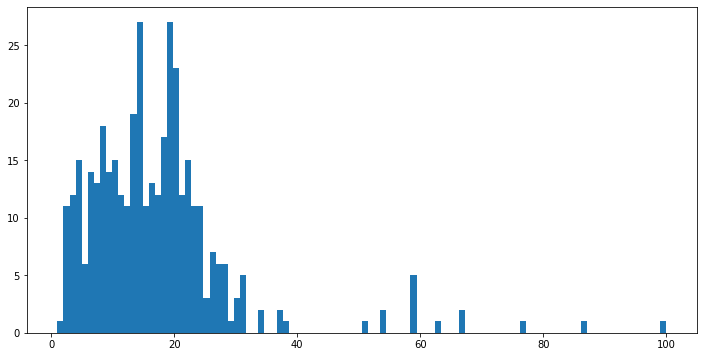

In [7]:
length = []
for name, group in pos_grp:
    length.append(len(group))

plt.figure(figsize=(12, 6))
plt.hist(length, bins = 100)

In [8]:
df1 = df.copy()
for name, group in pos_grp:
    if len(group) < 3:
        df1 = df1.drop(pos_grp.get_group(name).index)

pos_df1 = df1.drop(['v_x', 'v_y'], axis = 1)
pos_grp1 = pos_df1.groupby('pedestrian_ID')

12
378


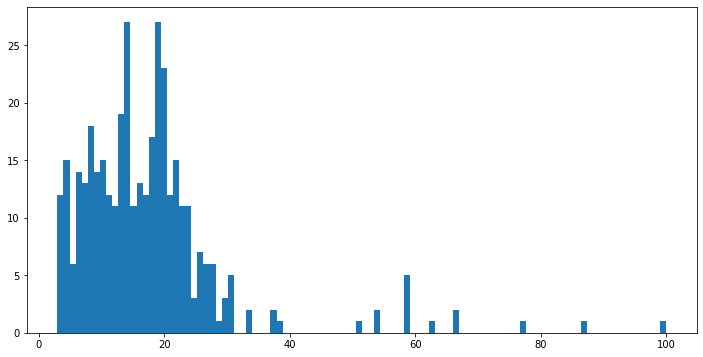

In [9]:
length = []
for name, group in pos_grp1:
    length.append(len(group))

plt.figure(figsize=(12, 6))
plt.hist(length, bins = 100)

newL = [x for x in length if x < 4]
print(len(newL))
print(len(length))

In [10]:
df_lstm = pd.DataFrame()
for name, group in pos_grp1:
    first_cols = group[['frame_number', 'pedestrian_ID']]
    second_cols = group[['pos_x', 'pos_y']]
    second_cols_converted = f.series_to_supervised(second_cols, 3)
    
    df_temp = pd.concat([first_cols, second_cols_converted], axis=1)
    df_lstm = pd.concat([df_lstm, df_temp])
    
df_lstm = df_lstm.dropna()
df_lstm = df_lstm.drop(['frame_number', 'pedestrian_ID'], axis = 1)
df_lstm.to_csv(f"datasets/csvs/lstms/seq_hotel.csv", index=False)

## Models

In [11]:
X = df_lstm.drop(['var1(t)', 'var2(t)'], axis = 1).values
y = df_lstm[['var1(t)', 'var2(t)']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3770, 1, 6) (3770, 2) (1617, 1, 6) (1617, 2)


In [12]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
verbose, epochs, batch_size = 0, 70, 16

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),

    tf.keras.layers.Dense(units=2)
])

model.compile(loss='mae', optimizer='adam', metrics='acc')

history = model.fit(X_train, y_train, epochs=50, batch_size=12, validation_data=(X_test, y_test), verbose=2, shuffle=False)


Epoch 1/50
315/315 - 6s - loss: 1.1211 - acc: 0.9332 - val_loss: 0.4320 - val_acc: 0.9579
Epoch 2/50
315/315 - 2s - loss: 0.3078 - acc: 0.9607 - val_loss: 0.2410 - val_acc: 0.9759
Epoch 3/50
315/315 - 2s - loss: 0.1823 - acc: 0.9780 - val_loss: 0.1516 - val_acc: 0.9870
Epoch 4/50
315/315 - 2s - loss: 0.1363 - acc: 0.9851 - val_loss: 0.1167 - val_acc: 0.9926
Epoch 5/50
315/315 - 2s - loss: 0.1145 - acc: 0.9883 - val_loss: 0.1070 - val_acc: 0.9932
Epoch 6/50
315/315 - 2s - loss: 0.1041 - acc: 0.9918 - val_loss: 0.0932 - val_acc: 0.9957
Epoch 7/50
315/315 - 2s - loss: 0.0948 - acc: 0.9934 - val_loss: 0.0853 - val_acc: 0.9951
Epoch 8/50
315/315 - 2s - loss: 0.0871 - acc: 0.9934 - val_loss: 0.0875 - val_acc: 0.9944
Epoch 9/50
315/315 - 2s - loss: 0.0832 - acc: 0.9942 - val_loss: 0.0812 - val_acc: 0.9957
Epoch 10/50
315/315 - 2s - loss: 0.0813 - acc: 0.9944 - val_loss: 0.0805 - val_acc: 0.9963
Epoch 11/50
315/315 - 2s - loss: 0.0775 - acc: 0.9942 - val_loss: 0.0803 - val_acc: 0.9957
Epoch 12

In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1, 32)             4992      
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 66        
Total params: 13,378
Trainable params: 13,378
Non-trainable params: 0
_________________________________________________________________


### Prediction

In [58]:
y_pred = []
for val in X_test:
    pred = model.predict(val[np.newaxis])
    y_pred.append(pred)

print(tf.keras.metrics.mean_absolute_error(y_pred, y_test).numpy())

[[0.03322618 1.26998856 1.47109964 ... 2.38018962 2.44699327 1.41535632]
 [1.28255814 0.11970422 0.4587997  ... 3.66221888 3.72902253 2.69738558]
 [1.4629079  0.56398943 0.01451448 ... 3.84256865 3.9093723  2.87773535]
 ...
 [2.39573989 3.66625733 3.86736841 ... 0.03502897 0.08987312 2.17478083]
 [2.44784621 3.71836365 3.91947473 ... 0.06818547 0.03894446 2.22570949]
 [1.38084517 2.6513626  2.85247369 ... 2.20235184 2.25719599 0.03398228]]


In [81]:
y_pred[0][0][0]

-0.055778347

#### Error

In [64]:
error = tf.keras.metrics.MeanAbsoluteError()
error.update_state(y_pred, y_test)
error.result().numpy()

3.0323954

# TEST

In [127]:
def make_forecast(model, df, size_of_prediction=2, no_of_forecasts=1, window_size=3):
  """
  Makes the forecast on the data

  Args:
    model (tensorflow sequential) -- the trained model with 2 output tensors
    df (pandas dataframe) -- the part of the dataframe on which the predictions are to be made
    dim (int) -- dimension of the prediction
    num (int) -- number of forecasts to be mad, the forecasts made would also be used to make the later forecasts
  """

  series = []
  forecasts = []

  try:
    for i in range(window_size,0,-1):
      for j in range(size_of_prediction):
        series.append(df.iloc[-i][j])
  except:
    print(f"Length of the dataframe={len(df)} is smaller than the window_size={window_size}. Add more data or reduce the window_size")



  for i in range(no_of_forecasts):
    predict = np.array(series[-window_size*size_of_prediction:])[np.newaxis]
    # print(predict)
    # print('--')
    # print(predict[np.newaxis].shape)
    forecast = model.predict(predict[-window_size*size_of_prediction:][np.newaxis])
    # print(f'forecast={forecast}')
    forecasts.append(forecast[0])
    for j in range(size_of_prediction):
      series.append(forecast[0][j])

  return np.array(forecasts)
      

In [128]:
temp = pos_df.iloc[-3:,-2:]
forecasts = make_forecast(model, temp, no_of_forecasts=5)
forecasts

array([[ 3.0356672, -2.6720977],
       [ 2.928692 , -3.7719054],
       [ 2.4759893, -2.3724554],
       [ 2.2767735, -2.4412947],
       [ 1.9583701, -1.5735222]], dtype=float32)

In [102]:
temp

,pos_x,pos_y
6541,2.695246,-8.296147
6542,3.353155,-1.422939
6543,3.615008,-5.564871


In [78]:
X_test[0][0]

array([ 9.6051172e-02, -5.6902647e+00,  5.7226009e-04, -5.6819618e+00,
       -4.2310665e-02, -5.7597107e+00])

In [90]:
temp = pos_df.iloc[-3:,-2:]
temp.iloc[-1][0]

3.6150081

In [92]:
type(df)

pandas.core.frame.DataFrame